In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class VideoExtractYUV:
    def __init__(self, filename, size, pix_fmt='uyvy', uv_sub_sampling='horizontal'):
        self.height, self.width = size
        self.frame_len = self.width * self.height * 2
        print('VideoCaptureYUY2: opening file %s' % filename)
        self.f = open(filename, 'rb')
        if not self.f:
            raise ValueError('Unable to open %s' % filename)
        self.shape = (self.height, self.width, 2)
        self.uv_sub_sampling = uv_sub_sampling
        self.pix_fmt = 'uyvy'
    
    def read_y_u_v(self):
        try:
            raw = self.f.read(self.frame_len)
            if len(raw) == 0: return False, None
            yuv = np.frombuffer(raw, dtype=np.uint8)
            if self.pix_fmt == "yuvy":
                y_id = 0
                u_id = 1
                v_id = 2
            elif self.pix_fmt == 'uyvy':
                y_id = 1
                u_id = 0
                v_id = 2
            else:
                raise ValueError('Pix format is not implemented')
            # read data    
            y = yuv[y_id:self.frame_len:2].reshape((self.height, self.width))
            print(y.shape)
            if self.uv_sub_sampling == 'horizontal':
                u = yuv[u_id:self.frame_len:4].reshape((self.height, self.width//2))
                v = yuv[v_id:self.frame_len:4].reshape((self.height, self.width//2))
            elif self.uv_sub_sampling == 'vertical':
                u = yuv[u_id:self.frame_len:4].reshape((self.height//2, self.width))
                v = yuv[v_id:self.frame_len:4].reshape((self.height//2, self.width))
            else:
                raise ValueError('{} subsampling is not supported.'.format(self.uv_sub_sampling))                  
        except Exception as e:
            print(str(e))
            return False, None
        return True, y,u,v

In [15]:
def get_full_yuv():
    data_name = "data/scalar_uyvy/input_1920x1080.uyvy"
    size = (1080, 1920)
    cap = VideoExtractYUV(data_name, size)
    success, y, u, v = cap.read_y_u_v()
    return y, u, v

def get_scalar_yuv():
    data_name = "data/scalar_uyvy/downscale_320x192.uyvy"
    size = (192, 320)
    cap = VideoExtractYUV(data_name, size)
    success, y, u, v = cap.read_y_u_v()
    return y, u, v

In [16]:
y, u, v = get_full_yuv()

VideoCaptureYUY2: opening file data/scalar_uyvy/input_1920x1080.uyvy
(1080, 1920)


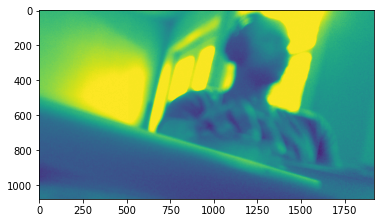

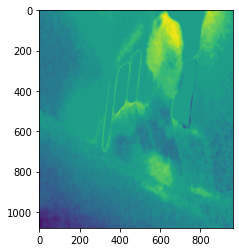

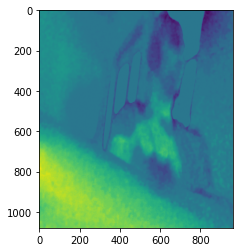

In [17]:
plt.imshow(y)
plt.show()
plt.imshow(u)
plt.show()
plt.imshow(v)
plt.show()

In [20]:
class ResizeAndConvertToUYVY(object):
    def __init__(self, resize_wh=None, intp_type=cv2.INTER_LINEAR, use_y_only=False):
        self.resize_wh = resize_wh
        self.intp_type = intp_type
        self.use_y_only = use_y_only

    def convert_splitted_yuv_to_uyvy(self, y, u, v):
        resize_wh = self.resize_wh
        intp_type = self.intp_type
        if resize_wh is not None:
            y = cv2.resize(y, resize_wh, interpolation=intp_type)
            u = cv2.resize(u, resize_wh, interpolation=intp_type)
            v = cv2.resize(v, resize_wh, interpolation=intp_type)

        uh = cv2.resize(u, (int(u.shape[1]/2), u.shape[0]))
        vh = cv2.resize(v, (int(v.shape[1]/2), v.shape[0]))
        uvh = cv2.merge([uh, vh])
        uv = uvh.reshape(y.shape)
        uyvy = cv2.merge([uv, y])
        if self.use_y_only:
            ret = uyvy[:, :, 1]
        else:
            ret = uyvy
        return ret

    def __call__(self, y, u, v):
        uyvy = self.convert_splitted_yuv_to_uyvy(y, u, v)
        return uyvy

In [21]:
Rop = ResizeAndConvertToUYVY(resize_wh=(320,192))
y, u, v = get_full_yuv()
uyvy_train_down = Rop(y,u,v)

ysc, usc, vsc = get_scalar_yuv()

VideoCaptureYUY2: opening file data/scalar_uyvy/input_1920x1080.uyvy
(1080, 1920)
VideoCaptureYUY2: opening file data/scalar_uyvy/downscale_320x192.uyvy
(192, 320)


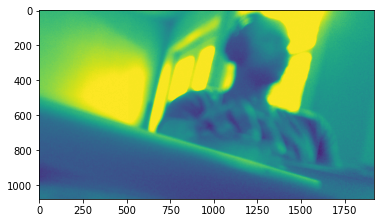

In [22]:
plt.imshow(y)
plt.show()

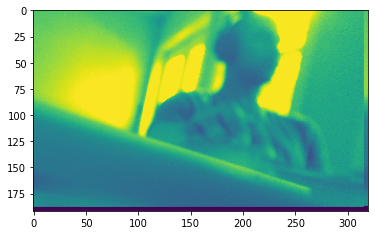

In [23]:
plt.imshow(ysc)
# print(np.max(ysc))
plt.show()

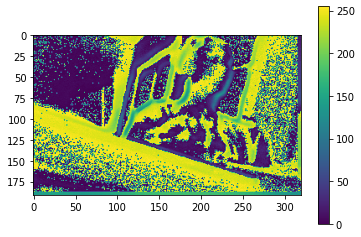

In [24]:
# plt.imshow(np.abs(ysc- cv2.resize(y, (320, 192), interpolation=cv2.INTER_LINEAR)))
plt.imshow(np.abs(ysc- uyvy_train_down[:,:,1]))
plt.colorbar()
plt.show()

In [25]:
# print(np.sum(np.abs(uyvy_down[:,:,1]- cv2.resize(y, (320, 192), interpolation=cv2.INTER_LINEAR)))